## **READ DATASET AND CREATE DATALOADERS**



**DATASET:**

The CIFAR10 dataset is a popular dataset for object recognition in computer vision. It consists of 60,000 32x32 RGB color images, with a balanced distribution of 10 classes, each containing 6,000 images. The dataset is partitioned into 50,000 training images and 10,000 test images.

**READ DATASET:**

**Data Augmentation** is done for train and test separately which helps the model to learn about the features. *transforms.RandomCrop* crops the images to 32X32 pixels with padding of 4 pixels. *transforms.RandomHorizontalFlip* randomly flips the images horizontally.

**CREATE DATALOADERS:**

*torch.utils.data.DataLoader* is used to load the data after transformation. *trainloader* is used to load the dataset in batches of size 128, shuffle the dataset and parallelize the loading the loading using 2 workers. *pin_memory* is set to enable faster data transfer between CPU and GPU when using CUDA. *testloader* is used to load the test set in batches of size 100.









In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np

# Setting seed
torch.manual_seed(20)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Define the transformations for the dataset
transform_train = transforms.Compose([
    # Random Cropping
    transforms.RandomCrop(32, padding=4),
    # Random Horizontal Flipping
    transforms.RandomHorizontalFlip(),
    # Convert image to tensor
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

# Load the CIFAR10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)

# Create the dataloaders for the dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2, pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


### Looking at the data

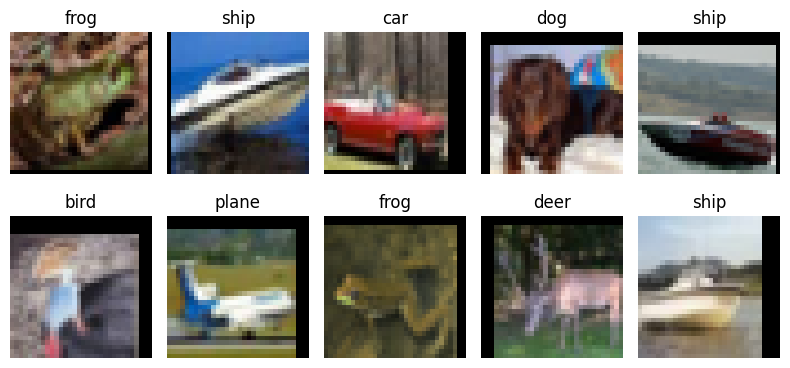

In [13]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# Get the first 10 images from the trainloader
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show the images in a grid
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(8, 4))
for i in range(2):
    for j in range(5):
        idx = i * 5 + j
        ax[i, j].imshow(images[idx].permute(1, 2, 0).numpy())
        ax[i, j].set_title(classes[labels[idx]])
        ax[i, j].axis('off')
plt.tight_layout()
plt.show()

The below code defines a Convolutional Neural Network (CNN) model for image classification. The model contain three main components: a *backbone* class, *block* class and *classifier* class.

**Backbone Class:**

It takes two parameters, '*num_blocks*' and '*num_conv_layers*' which define the number of blocks and number of convolutional layers of each block respectively.The first block takes as input the original image (3 channels) and outputs feature maps with 64 channels. The subsequent blocks take as input feature maps with 64 channels and output feature maps with the same number of channels, except for the last block which outputs feature maps with 256 channels.

**Classifier Class:**

 It takes two parameters, '*in_channels*' and '*num_classes*', which define the number of input channels and the number of output classes, respectively. The classifier applies *Spatial average pooling* to the output of the backbone and then applies a fully connected layer to produce the final classification result.

**Model Class:**

This class combines the backbone and classifier by creating two objects, backbone and classifier, which are the backbone and classifier of the model, respectively. The backbone object is an instance of the Backbone class, and the classifier object is an instance of the Classifier class. It takes three parameters, '*num_blocks*', '*num_conv_layers*', and 'num_classes', which define the number of blocks and convolutional layers in each block, and the number of output classes, respectively. In the forward pass, the input image is passed through the backbone to produce feature maps, which are then fed to the classifier to produce the final classification result.

Finally, the resulting vector is passed through the classifier object, which consists of a single fully connected layer, to obtain the predicted class probabilities for the input image.

**Input:**

**x (tensor):** input image tensor of shape (batch_size, channels, height, width)
Output:

**out (tensor):** tensor of shape (batch_size, num_classes) containing the predicted class probabilities for the input image.

**Architecture:**


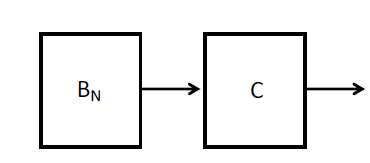

In [2]:
# Define a block that consists of multiple convolutional layers
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, num_conv_layers):
        super(Block, self).__init__()
        # Initialize the layers of the block
        layers = []
        # Add the first convolutional layer
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False))
        # Add batch normalization layer
        layers.append(nn.BatchNorm2d(out_channels))
        # Add a ReLU activation layer
        layers.append(nn.ReLU(inplace=True))
        # Add the remaining convolutional layers
        for i in range(num_conv_layers - 1):
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))

        # Create a sequential container for the layers of the block
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        # Pass the input tensor through the block layers and return the output tensor
        out = self.block(x)
        return out

# Define the backbone of the model
class Backbone(nn.Module):
    def __init__(self, num_blocks, num_conv_layers):
        super(Backbone, self).__init__()

        # Define the first convolutional layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        # Add batch normalization layer
        self.bn1 = nn.BatchNorm2d(64)
        # Add a ReLU activation layer
        self.relu = nn.ReLU(inplace=True)
        # Add max pooling layer
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Create a list of blocks for the backbone
        blocks = []
        in_channels = 64
        out_channels = 64
        # Add the specified number of blocks to the backbone
        for i in range(num_blocks):
            # If it's the last block, set the number of output channels to 256
            if i == num_blocks - 1:
                out_channels = 256
            # Add a block to the backbone
            blocks.append(Block(in_channels, out_channels, num_conv_layers))
            # Update the number of input channels for the next block
            in_channels = out_channels
        # Create a sequential container for the blocks of the backbone
        self.blocks = nn.Sequential(*blocks)

    def forward(self, x):
         # Pass the input tensor through the backbone layers and return the output tensor
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.blocks(out)

        return out

# Define the classifier of the model
class Classifier(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Classifier, self).__init__()
        # Add an adaptive average pooling layer to collapse the spatial dimensions
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        # Add a linear layer for classification
        self.fc = nn.Linear(in_channels, num_classes)

    def forward(self, x):
        # Pass the input tensor through the classifier layers and return the output tensor
        out = self.pool(x)
        # Flatten the pooled feature map
        out = out.view(out.size(0), -1)
        # Apply fully connected layer to produce the final output
        out = self.fc(out)
        return out


class Model(nn.Module):
    def __init__(self, num_blocks, num_conv_layers, num_classes):
        super(Model, self).__init__()

        # Create the backbone module
        self.backbone = Backbone(num_blocks, num_conv_layers)
        # Create the classifier module
        self.classifier = Classifier(256, num_classes)

    def forward(self, x):
        # Apply the backbone to the input image
        out = self.backbone(x)
        # Apply the classifier to the output of the backbone
        out = self.classifier(out)
        return out


## CREATE LOSS AND OPTIMIZER

The device is to GPU if it is available, otherwise sets it to
CPU. It then sets hyperparameters such as the number of classes, learning rate, number of epochs, number of blocks, and number of convolutional layers. It creates an instance of the Model class with these hyperparameters and moves it to the GPU (if available).

The *loss function* is defined as *cross-entropy loss*, which is commonly used in classification tasks. The optimizer is set as stochastic gradient descent (SGD) (used to update the weights of the neural network during training)

A *Learning rate scheduler* is defined as a multi-step scheduler, which adjusts the learning rate based on predefined milestones and a decay factor. In this case, the milestones are set at epoch 25 and 40, and the decay factor is set to 0.1. This helps to improve the performance of the model during training by gradually decreasing the learning rate.

**Input**: None

**Output**: The model, loss function, optimizer, and learning rate scheduler with their respective configurations

In [3]:
# Set the device to GPU if available, else CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Set hyperparameters
num_classes = 10
learning_rate = 0.1
num_epochs = 100
num_blocks = 3
num_conv_layers = 2

# Create an instance of the Model class and move it to the GPU (if available)
model = Model(num_blocks=num_blocks, num_conv_layers=num_conv_layers, num_classes=num_classes).to(device)
# Define the loss function as cross-entropy loss
criterion = nn.CrossEntropyLoss()
# Define the optimizer as stochastic gradient descent (SGD)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
# Define the learning rate scheduler as a multi-step scheduler, with milestones at epoch 25 and 40, and a decay factor of 0.1
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 75], gamma=0.1)

## TRAINING THE MODEL

We use two function *train* anad *validate* for training and validating the model.

**TRAIN:**
The train function trains a PyTorch neural network model on a given dataset.

***Inputs:***

**model:** a PyTorch neural network model to be trained

**criterion:** a loss function used to calculate the loss between the predicted and target outputs

**optimizer:** an optimization algorithm used to update the weights of the model during training

**scheduler:** a learning rate scheduler used to adjust the learning rate during training

**train_loader:** a PyTorch DataLoader object that loads the training dataset in batches

**device:** a PyTorch device object that specifies where to run the training (e.g., "cuda" for GPU or "cpu" for CPU)

**Steps:**

1.  Sets the model to training mode (model.train())
2.  Initializes variables to keep track of the loss and accuracy during training
3.  Iterates over the training data in batches using the *'train_loader'* DataLoader
4.  For each batch:
      1. Moves the inputs and targets to the device (GPU or CPU) using inputs.to(device) and targets.to(device)
      2. Clears the gradients from the previous iteration using optimizer.zero_grad()
      3. Passes the inputs through the model to get the predicted outputs using outputs = model(inputs)
      4. Calculates the loss using the criterion loss function using loss = criterion(outputs, targets)
      5. Computes the gradients of the loss with respect to the model parameters using backpropagation using loss.backward()
      6. Updates the model parameters using the optimizer using optimizer.step()
      7. Updates the running loss and accuracy

5. Updates the learning rate scheduler using scheduler.step()
6. Calculates the average training loss and accuracy for the entire epoch

**Outputs:**

Average training loss and accuracy as a tuple (train_loss, train_acc)

**VALIDATE:**

The validate function evaluates a PyTorch neural network model on a given test dataset.

**Inputs**:

**model:** a PyTorch neural network model to be evaluated
**criterion:** a loss function used to calculate the loss between the predicted and target outputs
**test_loader:** a PyTorch DataLoader object that loads the test dataset in batches
**device:** a PyTorch device object that specifies where to run the evaluation (e.g., "cuda" for GPU or "cpu" for CPU)

**Steps:**

1.  Sets the model to evaluation mode (model.eval())
2.  Initializes variables to keep track of the loss and accuracy during evaluation
3.  Disables gradient computation since we are only evaluating the model (using with torch.no_grad():)
4.  Iterates over the test data in batches using the test_loader DataLoader
5.  For each batch:
    1. Moves the inputs and targets to the device (GPU or CPU) using inputs.to(device) and targets.to(device)
    2. Passes the inputs through the model to get the predicted outputs using outputs = model(inputs)
    3. Calculates the loss using the criterion loss function using loss = criterion(outputs, targets)
    4. Updates the running loss and accuracy

6.  Calculates the average validation loss and accuracy for the entire test set

**Outputs:**

Average validation loss and accuracy as a tuple (test_loss, test_acc)




In [4]:
# OPTIONAL CODE
def train(model, criterion, optimizer, scheduler, train_loader, device):
    # Set model to train mode
    model.train()
    # Initialize variables for tracking loss and accuracy
    running_loss = 0.0
    correct = 0
    total = 0
    # Iterate over the training data
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move inputs and targets to the device (CPU or GPU) being used
        inputs, targets = inputs.to(device), targets.to(device)
        # Reset gradients
        optimizer.zero_grad()
        # Make a forward pass through the model to get the output
        outputs = model(inputs)
        # Calculate the loss
        loss = criterion(outputs, targets)
        # Compute gradients and update the weights
        loss.backward()
        optimizer.step()
        # Update variables for tracking loss and accuracy
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    # Update the learning rate using the scheduler
    scheduler.step()
    # Calculate the average training loss and accuracy
    train_loss = running_loss / len(train_loader)
    train_acc = 100.0 * correct / total
    # Returns train loss and train accuracy 
    return train_loss, train_acc


def validate(model, criterion, test_loader, device):
    # Set model to evaluation mode
    model.eval()
    # Initialize variables for tracking loss and accuracy
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        # Iterate over the validation data
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            # Move inputs and targets to the device (CPU or GPU) being used
            inputs, targets = inputs.to(device), targets.to(device)

            # Make a forward pass through the model to get the output
            outputs = model(inputs)
            # Calculate the loss
            loss = criterion(outputs, targets)

            # Update variables for tracking loss and accuracy
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    # Calculate the average validation loss and accuracy
    test_loss = running_loss / len(test_loader)
    test_acc = 100.0 * correct / total

    # Returns test loss and test accuracy
    return test_loss, test_acc


**Input:**

**model:** PyTorch model
**criterion:** criterion
**optimizer:** optimizer
**scheduler:** learning rate scheduler
**trainloader:**  training dataset 
**testloader:** validation dataset
**num_epochs:** number of epochs to train the model

**Steps:**
1.  The number of epochs to train the model is specified as num_epochs.
2.  Four empty lists are created to store the training and validation loss and accuracy values for each epoch: train_loss, train_acc, val_loss, and val_acc.
3.  The device is set to GPU (if available).
4. The model is trained for the specified number of epochs (num_epochs).
5. For each epoch:
    1. The model is set to training mode (model.train()).
    2. Variables are initialized to track the running loss and number of correct predictions during training.
    3. The training data is looped over in batches.
    4. For each batch, the gradients of the optimizer are zeroed (optimizer.zero_grad()), the forward pass is made through the model (model(images)), and the loss is calculated using the criterion (criterion(outputs, labels)).
    5. The backward pass is made through the loss to update the optimizer (loss.backward() and optimizer.step()).
    6. The number of correct predictions is calculated (predicted.eq(labels).sum().item()), and the running loss and total number of images seen are updated.
    7. At the end of each epoch, the average loss and accuracy are calculated and appended to the training lists (train_loss and train_acc).
    8. The epoch number, training loss, and training accuracy are printed.
    9. The model is set to evaluation mode (model.eval()).
    10. Variables are initialized to track the running loss and number of correct predictions during validation.
    11. The validation data is looped over in batches.
    12. For each batch, the forward pass is made through the model (model(images)), and the loss and number of correct predictions are calculated.
    13. At the end of each epoch, the average loss and accuracy are calculated and appended to the validation lists (val_loss and val_acc).
    14. The validation loss and accuracy are printed.
    15. The learning rate scheduler is updated (scheduler.step()).

**Output:**

*train_loss, train_acc, val_loss, and val_acc*. These lists store the training and validation loss and accuracy values for each epoch, respectively.

In [5]:
# Define the number of epochs to train for
num_epochs = 50
# Initialize empty lists to store training and validation loss and accuracy
train_loss = []
train_acc = []
val_loss = []
val_acc = []

# Use GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Iterate over each epoch
for epoch in range(num_epochs):

    
    # Train
    # Set the model to training mode
    model.train()
    # Initialize variable for tracking running loss
    running_loss = 0.0
    # Initialize variable for tracking number of correct predictions
    correct = 0
    # Initialize variable for tracking total number of predictions
    total = 0

    # Iterate over the training data
    for images, labels in trainloader:
        # Move the input and target tensors to the device being used
        images, labels = images.to(device), labels.to(device)

        # Reset gradients
        optimizer.zero_grad()

        # Make a forward pass through the model to get the output
        outputs = model(images)
        # Calculate the loss
        loss = criterion(outputs, labels)
        # Backpropagate the loss
        loss.backward()
        # Update the weights
        optimizer.step()

        # Get the predicted class for each input
        _, predicted = outputs.max(1)
        # Increment the total number of predictions by the number of inputs in the batch
        total += labels.size(0)
        # Increment the number of correct predictions by the number of inputs in the batch that were predicted correctly
        correct += predicted.eq(labels).sum().item()

        # Add the batch loss to the running loss
        running_loss += loss.item()

    # Calculate the epoch loss by averaging the running loss over the number of batches
    epoch_loss = running_loss / len(trainloader)
    # Calculate the epoch accuracy by dividing the number of correct predictions by the total number of predictions
    epoch_acc = correct / total

    # Add the epoch loss to the list of training losses
    train_loss.append(epoch_loss)
    # Add the epoch accuracy to the list of training accuracies
    train_acc.append(epoch_acc)

    print(f"Epoch: {epoch + 1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}")

    # Validate
    # Set the model to evaluation mode
    model.eval()
    # Initialize variable for tracking running loss
    running_loss = 0.0
    # Initialize variable for tracking number of correct predictions
    correct = 0
    # Initialize variable for tracking total number of predictions
    total = 0

    with torch.no_grad():
        # Iterate over the validation data
        for images, labels in testloader:
            # Move the input and target tensors to the device being used
            images, labels = images.to(device), labels.to(device)

            # Make a forward pass through the model to get the output
            outputs = model(images)
            # Calculate the loss
            loss = criterion(outputs, labels)

            # Get the predicted class for each input
            _, predicted = outputs.max(1)
            # Increment the total number of predictions by the number of inputs in the batch
            total += labels.size(0)
            # Increment the number of correct predictions by the number of inputs in the batch that were predicted correctly
            correct += predicted.eq(labels).sum().item()
            # Add the batch loss to the running loss
            running_loss += loss.item()
        # Calculate the epoch loss by averaging the running loss over the number of batches
        epoch_loss = running_loss / len(testloader)
        # Calculate the epoch accuracy by dividing the number of correct predictions by the total number of predictions
        epoch_acc = correct / total

        # Add the epoch loss
        val_loss.append(epoch_loss)
        # Add the epoch accuracy
        val_acc.append(epoch_acc)

        print(f"Val Loss: {epoch_loss:.4f}, Val Accuracy: {epoch_acc:.4f}")
        scheduler.step()

Epoch: 1/50, Train Loss: 1.5245, Train Accuracy: 0.4311
Val Loss: 1.2966, Val Accuracy: 0.5456
Epoch: 2/50, Train Loss: 1.1261, Train Accuracy: 0.5942
Val Loss: 1.9540, Val Accuracy: 0.4115
Epoch: 3/50, Train Loss: 0.9648, Train Accuracy: 0.6570
Val Loss: 1.6770, Val Accuracy: 0.5265
Epoch: 4/50, Train Loss: 0.8594, Train Accuracy: 0.6967
Val Loss: 1.1147, Val Accuracy: 0.6324
Epoch: 5/50, Train Loss: 0.7748, Train Accuracy: 0.7297
Val Loss: 0.8146, Val Accuracy: 0.7142
Epoch: 6/50, Train Loss: 0.7073, Train Accuracy: 0.7548
Val Loss: 0.9400, Val Accuracy: 0.7060
Epoch: 7/50, Train Loss: 0.6595, Train Accuracy: 0.7709
Val Loss: 0.9684, Val Accuracy: 0.6959
Epoch: 8/50, Train Loss: 0.6145, Train Accuracy: 0.7889
Val Loss: 0.8011, Val Accuracy: 0.7274
Epoch: 9/50, Train Loss: 0.5813, Train Accuracy: 0.7988
Val Loss: 1.2090, Val Accuracy: 0.6378
Epoch: 10/50, Train Loss: 0.5553, Train Accuracy: 0.8096
Val Loss: 0.8181, Val Accuracy: 0.7482
Epoch: 11/50, Train Loss: 0.5267, Train Accuracy:

In [6]:
# Print overall averages
train_loss_avg = sum(train_loss) / len(train_loss)
train_acc_avg = sum(train_acc) / len(train_acc)
val_loss_avg = sum(val_loss) / len(val_loss)
val_acc_avg = sum(val_acc) / len(val_acc)

print(f"\nOverall Train Loss: {train_loss_avg:.4f}, Overall Train Accuracy: {train_acc_avg:.4f}")
print(f"Overall Val Loss: {val_loss_avg:.4f}, Overall Val Accuracy: {val_acc_avg:.4f}")


Overall Train Loss: 0.4490, Overall Train Accuracy: 0.8427
Overall Val Loss: 0.8094, Overall Val Accuracy: 0.7512


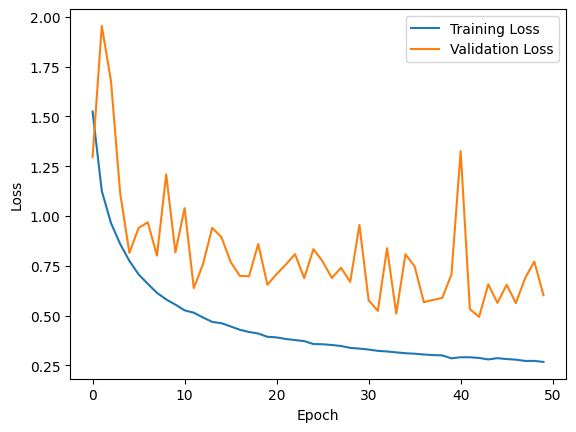

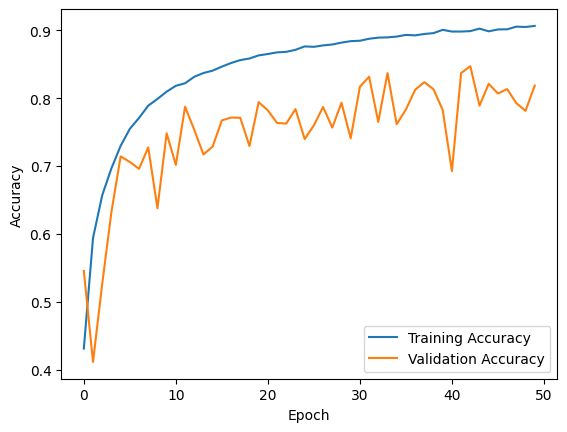

In [7]:
# import the necessary module
import matplotlib.pyplot as plt

# plot the training and validation loss curves
# plot the training loss
plt.plot(train_loss, label='Training Loss')
# plot the validation loss
plt.plot(val_loss, label='Validation Loss')
# set the label for the x-axis
plt.xlabel('Epoch')
# set the label for the y-axis
plt.ylabel('Loss')
# add a legend to the plot
plt.legend()
# display the plot
plt.show()

# plot the training and validation accuracy curves
# plot the training accuracy
plt.plot(train_acc, label='Training Accuracy')
# plot the validation accuracy
plt.plot(val_acc, label='Validation Accuracy')
# set the label for the x-axis
plt.xlabel('Epoch')
# set the label for the y-axis
plt.ylabel('Accuracy')
# add a legend to the plot
plt.legend()
# display the plot
plt.show()

The model was trained for 50 epochs on some dataset. During the training process, the model's performance interms of loss and accuracy has improved over time. 

The training loss has decreased from approximately 1.5 to 0.2. 
The training accuracy has increased from 43.11% to 90.6%.

The validation loss has decreased from approximately 1.3 to 0.6.
The validation accuracy has increased from 54.56% to 81.85%.
